Źrodło danych: https://archive.ics.uci.edu/dataset/33/dermatology

Ta baza danych zawiera 34 atrybuty, z których 33 mają wartości liniowe, a jeden jest nominalny.
Różnicowa diagnoza chorób erytematyczno-łuszczycowych jest rzeczywistym problemem w dermatologii. 
Wszystkie one mają wspólne cechy kliniczne (zaczerwienienie i łuszczenie), z bardzo małymi różnicami. 
Choroby w tej grupie to łuszczyca, łojotokowe zapalenie skóry, liszaj płaski, łupież różowy, przewlekłe zapalenie skóry i łupież rubra mieszkowy. 
Zazwyczaj do diagnozy konieczna jest biopsja, ale niestety te choroby mają także wiele wspólnych cech histopatologicznych. 
Kolejnym utrudnieniem dla różnicowej diagnozy jest to, że choroba może wykazywać cechy innej choroby na początkowym etapie, 
a następnie charakterystyczne cechy na kolejnych etapach. Pacjenci zostali najpierw ocenieni klinicznie pod kątem 12 cech. 
Następnie pobrano próbki skóry do oceny 22 cech histopatologicznych. Wartości cech histopatologicznych są określane przez analizę próbek pod mikroskopem.
W zestawie danych skonstruowanym dla tej dziedziny, cecha historii rodzinnej ma wartość 1, 
jeśli jakiekolwiek z tych chorób zostało zaobserwowane w rodzinie, a 0 w przeciwnym razie. 
Cecha wieku po prostu reprezentuje wiek pacjenta. Każda inna cecha (kliniczna i histopatologiczna) została przypisana stopniowi w zakresie od 0 do 3. 
Tutaj 0 oznacza, że cecha nie była obecna, 3 oznacza największą możliwą ilość, a 1, 2 wskazują na wartości pośrednie względem siebie.

Nazwy i numery identyfikacyjne pacjentów zostały niedawno usunięte z bazy danych.

# 

Import potrzebnych bibliotek

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

Wczytanie danych z pliku

In [38]:
# Ścieżka do pliku
file_path = "data/dermatology.data" 

# Nazwy kolumn w kolejności według numerów
column_names = [
    "erythema",
    "scaling",
    "definite_borders",
    "itching",
    "koebner_phenomenon",
    "polygonal_papules",
    "follicular_papules",
    "oral_mucosal_involvement",
    "knee_and_elbow_involvement",
    "scalp_involvement",
    "family_history",
    "melanin_incontinence",
    "eosinophils_in_the_infiltrate",
    "PNL_infiltrate",
    "fibrosis_of_the_papillary_dermis",
    "exocytosis",
    "acanthosis",
    "hyperkeratosis",
    "parakeratosis",
    "clubbing_of_the_rete_ridges",
    "elongation_of_the_rete_ridges",
    "thinning_of_the_suprapapillary_epidermis",
    "spongiform_pustule",
    "munro_microabcess",
    "focal_hypergranulosis",
    "disappearance_of_the_granular_layer",
    "vacuolisation_and_damage_of_basal_layer",
    "spongiosis",
    "saw_tooth_appearance_of_retes",
    "follicular_horn_plug",
    "perifollicular_parakeratosis",
    "inflammatory_monoluclear_inflitrate",
    "band_like_infiltrate",
    "age",
    "class"  # Ostatnia kolumna reprezentuje klasę/chorobę (1-6)
]

# Ze względu na strukturę pliku można użyć funkcji read_csv
df = pd.read_csv(file_path, header=None, names=column_names)

# Wyświetlenie całego DataFrame
df


,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw_tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,2,0,25,4
362,3,2,1,0,1,0,0,0,0,0,...,1,0,1,0,0,0,2,0,36,4
363,3,2,2,2,3,2,0,2,0,0,...,0,3,0,3,0,0,2,3,28,3
364,2,1,3,1,2,3,0,2,0,0,...,0,2,0,1,0,0,2,3,50,3


Zamiana znaków "?" na wartości NaN

In [39]:
df.replace("?", float("NaN"), inplace=True)

df

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw_tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,2,0,25,4
362,3,2,1,0,1,0,0,0,0,0,...,1,0,1,0,0,0,2,0,36,4
363,3,2,2,2,3,2,0,2,0,0,...,0,3,0,3,0,0,2,3,28,3
364,2,1,3,1,2,3,0,2,0,0,...,0,2,0,1,0,0,2,3,50,3


Sortowanie według wieku rosnąco (wiek jako tekst) w celu lepszej wizualizacji danych na wykresie

In [40]:
df = df.sort_values(by='age')

Wyświetlenie statystyk opisowych dla każdej kolumny

In [41]:
df.describe()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,focal_hypergranulosis,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw_tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,class
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,...,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2.068306,1.795082,1.549180,1.366120,0.633880,0.448087,0.166667,0.377049,0.614754,0.519126,...,0.393443,0.464481,0.456284,0.953552,0.453552,0.103825,0.114754,1.866120,0.554645,2.803279
std,0.664753,0.701527,0.907525,1.138299,0.908016,0.957327,0.570588,0.834147,0.982979,0.905639,...,0.849406,0.864899,0.954873,1.130172,0.954744,0.450433,0.488723,0.726108,1.105908,1.597803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000
75%,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,4.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,6.000000


Histogram dla kolumny Age

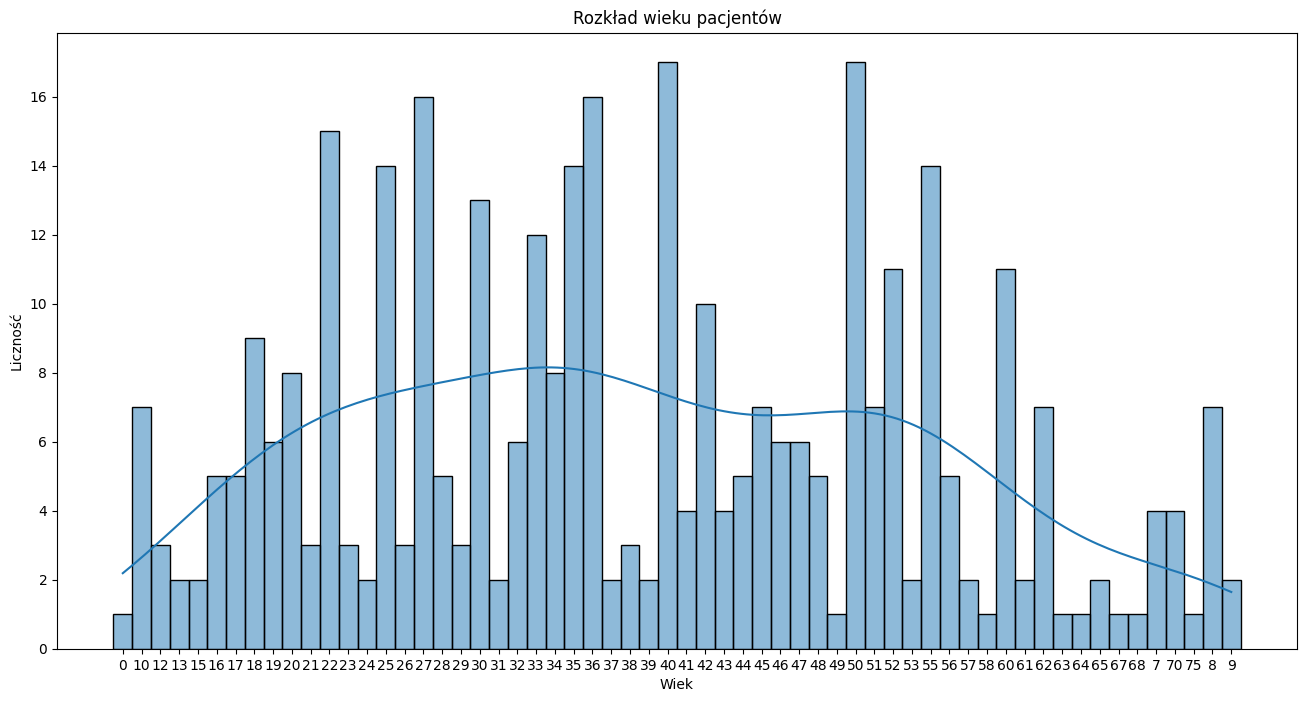

In [42]:
plt.figure(figsize=(16, 8))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Rozkład wieku pacjentów')
plt.xlabel('Wiek')
plt.ylabel('Liczność')
plt.show()

Wykres pudełkowy (box plot) dla cechy Age w zależności od klasy

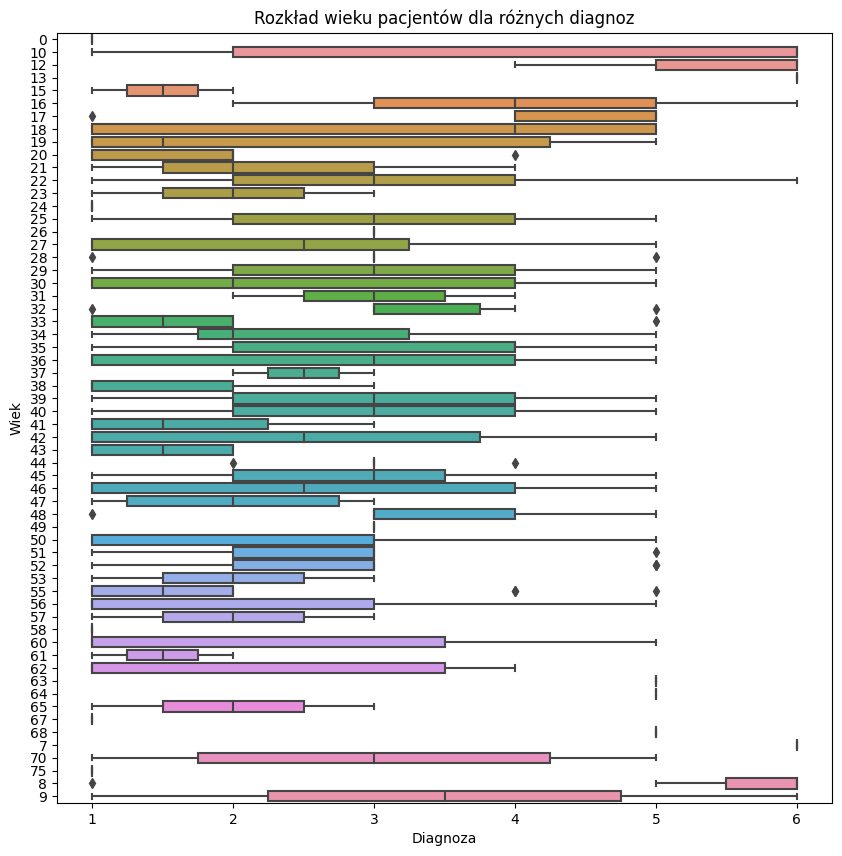

In [43]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='class', y='age', data=df)
plt.title('Rozkład wieku pacjentów dla różnych diagnoz')
plt.xlabel('Diagnoza')
plt.ylabel('Wiek')
plt.show()

Znajdowanie pustych wartości w całym DataFrame

In [44]:
missing_values = df.isna().sum()

missing_values

erythema                                    0
scaling                                     0
definite_borders                            0
itching                                     0
koebner_phenomenon                          0
polygonal_papules                           0
follicular_papules                          0
oral_mucosal_involvement                    0
knee_and_elbow_involvement                  0
scalp_involvement                           0
family_history                              0
melanin_incontinence                        0
eosinophils_in_the_infiltrate               0
PNL_infiltrate                              0
fibrosis_of_the_papillary_dermis            0
exocytosis                                  0
acanthosis                                  0
hyperkeratosis                              0
parakeratosis                               0
clubbing_of_the_rete_ridges                 0
elongation_of_the_rete_ridges               0
thinning_of_the_suprapapillary_epi

Można zauważyć, że tylko w kolumnie age brakuje wieku dla paru osób. Jest to około 2% wszystkich rekordów. Można w tym wypadku uzupełnić brakujące wartości, na przykład medianą.

In [45]:
# Wypełnienie brakujących wartości medianą wieku
age_median = df['age'].median()
df['age'].fillna(age_median, inplace=True)

Zamiana wartości Age na typ całkowity (żeby przygotować dane do dalszych obliczeń) i ponowne sortowanie.

In [46]:
# Zamiana wartości Age na int
df['age'] = df['age'].astype(int)

# Ponowne sortowanie według Age
df = df.sort_values(by='age')

# Wyświetlenie DataFrame po sortowaniu
df

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw_tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,age,class
119,1,1,1,1,1,0,0,0,2,2,...,0,0,0,0,0,0,0,2,0,1
239,2,2,2,1,0,0,2,0,2,2,...,0,0,2,0,2,2,2,0,7,6
184,2,2,1,0,0,0,3,0,2,0,...,0,0,2,0,3,3,2,0,7,6
122,1,1,2,0,0,0,3,0,3,0,...,0,0,0,0,2,2,2,0,7,6
349,2,2,1,0,0,0,2,0,2,0,...,0,0,3,0,2,2,2,0,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2,2,0,2,1,0,0,0,0,0,...,0,0,3,0,0,0,3,0,70,4
211,2,3,2,0,0,0,0,0,3,2,...,0,0,0,0,0,0,1,0,70,1
284,2,2,2,1,0,0,0,0,0,0,...,0,0,2,0,0,0,2,0,70,2
298,2,1,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,70,5


Sprawdźmy, które cechy mają najwyższą korelację z klasą.

In [47]:
# Obliczenie macierzy korelacji między cechami a klasą
correlations = df.corr()['class'].drop('class')

In [48]:
# Wybranie cech, które mają największą korelację z klasą dla klasyfikatora Naive Bayes
selected_features_naive_bayes = correlations.abs().nlargest(34).index.tolist()

# Wyświetlenie cech i ich korelacji z klasą dla klasyfikatora Naive Bayes
print(correlations[selected_features_naive_bayes])

thinning_of_the_suprapapillary_epidermis   -0.684864
clubbing_of_the_rete_ridges                -0.668781
PNL_infiltrate                             -0.550195
scalp_involvement                          -0.533208
fibrosis_of_the_papillary_dermis            0.526976
munro_microabcess                          -0.520995
follicular_papules                          0.477813
scaling                                    -0.468688
perifollicular_parakeratosis                0.457025
spongiform_pustule                         -0.449407
follicular_horn_plug                        0.431972
disappearance_of_the_granular_layer        -0.427348
parakeratosis                              -0.420742
definite_borders                           -0.391974
knee_and_elbow_involvement                 -0.383305
elongation_of_the_rete_ridges              -0.357924
erythema                                   -0.335537
exocytosis                                  0.283433
age                                        -0.

In [49]:
# Wybranie cech, które mają największą korelację z klasą dla klasyfikatora Random Forest
selected_features_random_forest = correlations.abs().nlargest(26).index.tolist()

# Wyświetlenie cech i ich korelacji z klasą dla klasyfikatora Random Forest
print(correlations[selected_features_random_forest])

thinning_of_the_suprapapillary_epidermis   -0.684864
clubbing_of_the_rete_ridges                -0.668781
PNL_infiltrate                             -0.550195
scalp_involvement                          -0.533208
fibrosis_of_the_papillary_dermis            0.526976
munro_microabcess                          -0.520995
follicular_papules                          0.477813
scaling                                    -0.468688
perifollicular_parakeratosis                0.457025
spongiform_pustule                         -0.449407
follicular_horn_plug                        0.431972
disappearance_of_the_granular_layer        -0.427348
parakeratosis                              -0.420742
definite_borders                           -0.391974
knee_and_elbow_involvement                 -0.383305
elongation_of_the_rete_ridges              -0.357924
erythema                                   -0.335537
exocytosis                                  0.283433
age                                        -0.

Zajmijmy się teraz normalizacją danych w naszym DataFrame.

In [50]:
# Inicjalizacja obiektu normalizacji Min-Max
scaler = MinMaxScaler()

# Wybranie kolumn do znormalizowania (bez kolumny "class")
columns_to_normalize = df.columns.drop("class")

# Normalizacja dla wybranych kolumn
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Wyświetlenie znormalizowanego DataFrame
df

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_of_the_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw_tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,age,class
119,0.333333,0.333333,0.333333,0.333333,0.333333,0.0,0.000000,0.0,0.666667,0.666667,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.666667,0.000000,1
239,0.666667,0.666667,0.666667,0.333333,0.000000,0.0,0.666667,0.0,0.666667,0.666667,...,0.0,0.0,0.666667,0.0,0.666667,0.666667,0.666667,0.000000,0.093333,6
184,0.666667,0.666667,0.333333,0.000000,0.000000,0.0,1.000000,0.0,0.666667,0.000000,...,0.0,0.0,0.666667,0.0,1.000000,1.000000,0.666667,0.000000,0.093333,6
122,0.333333,0.333333,0.666667,0.000000,0.000000,0.0,1.000000,0.0,1.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.666667,0.666667,0.666667,0.000000,0.093333,6
349,0.666667,0.666667,0.333333,0.000000,0.000000,0.0,0.666667,0.0,0.666667,0.000000,...,0.0,0.0,1.000000,0.0,0.666667,0.666667,0.666667,0.000000,0.093333,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,0.666667,0.666667,0.000000,0.666667,0.333333,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.933333,4
211,0.666667,1.000000,0.666667,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.666667,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.933333,1
284,0.666667,0.666667,0.666667,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.666667,0.0,0.000000,0.000000,0.666667,0.000000,0.933333,2
298,0.666667,0.333333,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.933333,5


# Naive Bayes Classifier

Model, który zostanie tutaj wykorzystany, to naiwny klasyfikator bayesowski. Jest to rodzaj algorytmu klasyfikacji probabilistycznej oparty na twierdzeniu Bayesa. Algorytm ten zakłada niezależność wszystkich cech, dlatego nazywany jest "naiwnym" (ang. naive). Choć założenie to może być dość silne i rzadko spełnione w rzeczywistych danych, algorytm ten jest prosty i działa dobrze w wielu przypadkach, szczególnie gdy dane są odpowiednio przetworzone lub mają właściwości zbliżone do niezależności. Naive Bayes znajduje zastosowanie w wielu dziedzinach, takich jak analiza tekstu, klasyfikacja e-maili jako spam/nie-spam, diagnostyka medyczna, itp.

In [51]:
# Cechy jako zbiór x
x = df[selected_features_naive_bayes].values

# Klasy jako zbiór y
y = df['class'].values

# Podzielenie danych na zbiór treningowy i testowy w proporcji 80:20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Utworzenie naiwnego klasyfikatora bayesowskiego
nb_model = GaussianNB()

# Trenowanie modelu na danych treningowych
nb_model.fit(x_train, y_train)

# Dokonanie predykcji na danych testowych
y_pred = nb_model.predict(x_test)

Obliczenie dokładności modelu

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy dla modelu modelu Naive Bayes: {accuracy:.4f}")

Accuracy dla modelu modelu Naive Bayes: 0.8649


# Random Forest Classifier

Model Random Forest to złożony algorytm klasyfikacji i regresji oparty na technice ensemble learning. W skrócie, Random Forest tworzy zbiór drzew decyzyjnych i łączy ich wyniki, aby uzyskać bardziej stabilne i dokładne prognozy.

Random Forest działa poprzez losowe wybieranie próbek ze zbioru treningowego i losowe wybieranie cech dla każdego drzewa w lesie. W ten sposób każde drzewo jest nieco inne, co pomaga uniknąć nadmiernego dopasowania do danych treningowych (overfitting). Następnie, gdy chcemy sklasyfikować nową próbkę lub dokonać predykcji, każde drzewo w lesie wydaje swoją opinię, a ostateczna decyzja jest podejmowana na podstawie głosowania lub uśredniania wyników drzew.

Dzięki tej technice Random Forest ma zdolność do radzenia sobie z złożonymi zbiorami danych, ogranicza ryzyko overfittingu i jest stosunkowo odporny na obecność szumu czy nieistotnych cech. Może być wykorzystywany zarówno do problemów klasyfikacji, jak i regresji.

Random Forest znajduje zastosowanie w różnych dziedzinach, w tym w analizie finansowej, przetwarzaniu obrazów, medycynie, marketingu i wielu innych, gdzie istnieje potrzeba modelowania złożonych zależności między danymi.

In [53]:
# Podział zbioru na cechy i etykiety
x = df[selected_features_random_forest]
y = df['class']

# Podział zbioru na zbiór treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Tworzenie modelu Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Trenowanie modelu
rf_model.fit(x_train, y_train)

# Predykcja na zbiorze testowym
y_pred_rf = rf_model.predict(x_test)

In [54]:
# Obliczenie dokładności (accuracy) dla modelu Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Wyświetlenie wyniku dokładności dla modelu Random Forest
print(f"Accuracy dla modelu Random Forest: {accuracy_rf:.4f}")

Accuracy dla modelu Random Forest: 0.9865


Dowód, na to, że odpowiednia liczba najistotniejszych cech wybranych do klasyfikatora Random Forest to 26, gdyż wybranie 27 i więcej nie poprawia wyniku accuracy

In [55]:
for i in range(1, 35):
    # Wybór i cech o najwyższych korelacjach z klasą
    selected_features_random_forest = correlations.abs().nlargest(i).index.tolist()

    # Wybór cech i etykiety
    x = df[selected_features_random_forest]
    y = df['class']

    # Podział zbioru na zbiór treningowy i testowy
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Tworzenie modelu Random Forest
    rf_model = RandomForestClassifier(random_state=42)

    # Trenowanie modelu
    rf_model.fit(x_train, y_train)

    # Predykcja na zbiorze testowym
    y_pred_rf = rf_model.predict(x_test)

    # Obliczenie dokładności (accuracy) dla modelu Random Forest
    accuracy_rf = accuracy_score(y_test, y_pred_rf)

    # Wyświetlenie wyniku dokładności dla modelu Random Forest wraz z ilością użytych cech
    print("Ilość cech: %d, Accuracy dla modelu Random Forest: %f" % (i, accuracy_rf))

Ilość cech: 1, Accuracy dla modelu Random Forest: 0.486486
Ilość cech: 2, Accuracy dla modelu Random Forest: 0.486486
Ilość cech: 3, Accuracy dla modelu Random Forest: 0.581081
Ilość cech: 4, Accuracy dla modelu Random Forest: 0.581081
Ilość cech: 5, Accuracy dla modelu Random Forest: 0.756757
Ilość cech: 6, Accuracy dla modelu Random Forest: 0.756757
Ilość cech: 7, Accuracy dla modelu Random Forest: 0.824324
Ilość cech: 8, Accuracy dla modelu Random Forest: 0.810811
Ilość cech: 9, Accuracy dla modelu Random Forest: 0.824324
Ilość cech: 10, Accuracy dla modelu Random Forest: 0.824324
Ilość cech: 11, Accuracy dla modelu Random Forest: 0.824324
Ilość cech: 12, Accuracy dla modelu Random Forest: 0.864865
Ilość cech: 13, Accuracy dla modelu Random Forest: 0.878378
Ilość cech: 14, Accuracy dla modelu Random Forest: 0.878378
Ilość cech: 15, Accuracy dla modelu Random Forest: 0.864865
Ilość cech: 16, Accuracy dla modelu Random Forest: 0.878378
Ilość cech: 17, Accuracy dla modelu Random Forest

# Wnioski

## Naiwny klasyfikator bayesowski

#### Wyłączenie ponownego sortowania (zaraz po zamianie Age z tekstu na liczby) według wieku sprawia, że dokładność klasyfikatora bayesowskiego spada.

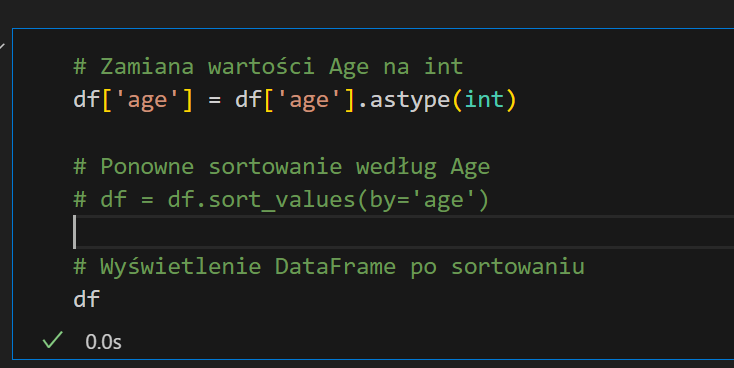

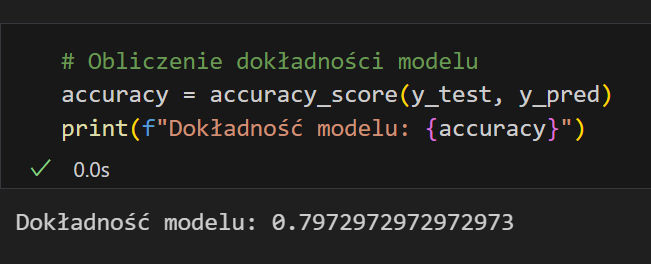

#### Ponowne włączenie sortowania

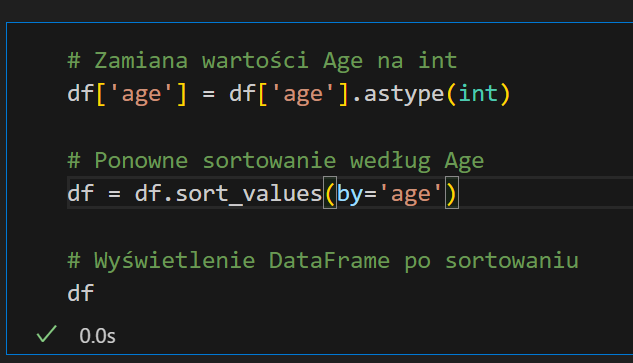

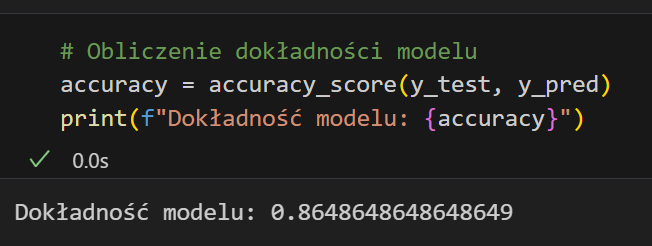

### Największe accuracy score dla Naive Bayes uzyskujemy, gdy wybierzemy 24 najistotniejsze cechy, potem dokładność się już nie zwiększa:

Przykład 1 - 23 najistotniejsze cechy

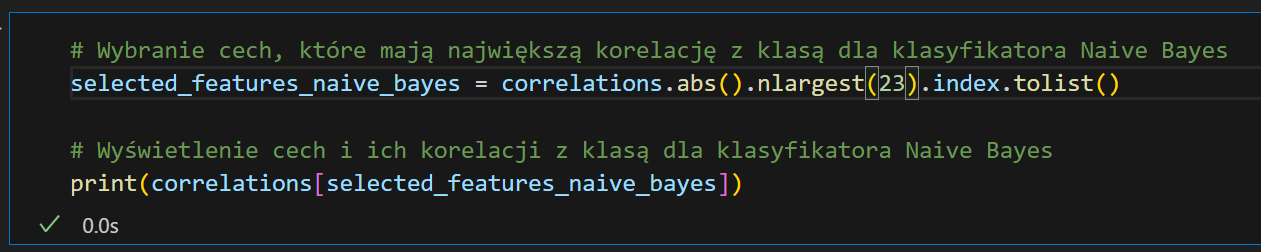

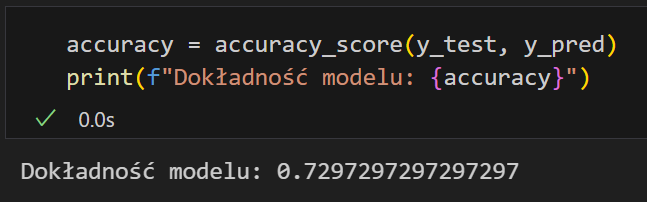

Przykład 2 - 24 najistotniejsze cechy

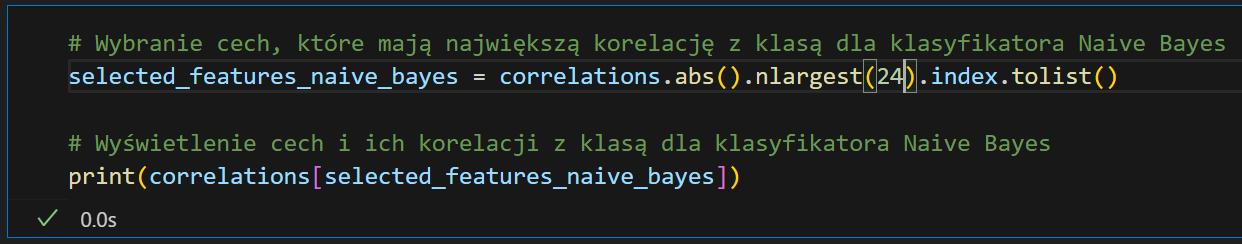

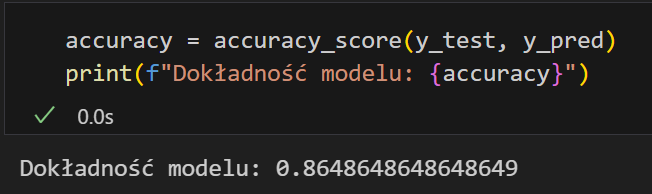

Przykład 3 - wszystkie cechy

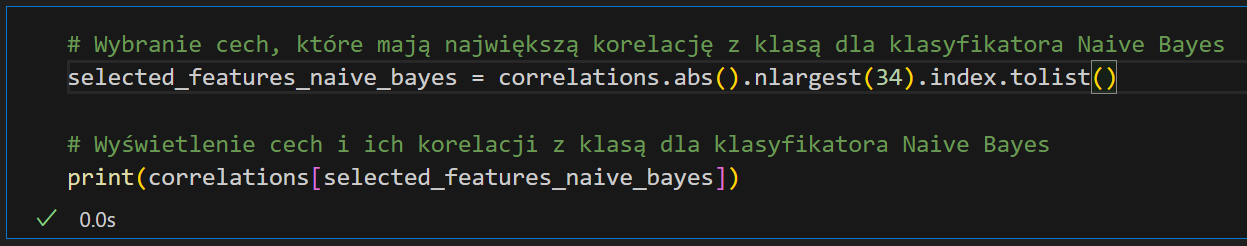

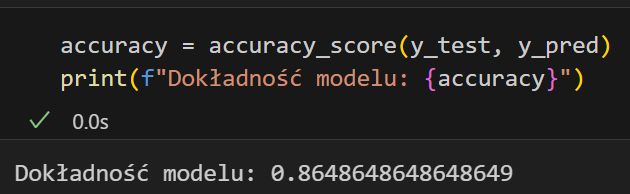

#### Zatem ostateczną liczbą cech dla Naive Bayes jest 24.